In [110]:
# Import used libraries
import os
import re
import random
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics
import umap
import umap.plot
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

In [112]:
# Define needed paths
root_path = Path('/').joinpath(*Path(os.getcwd()).parts[1:3])
img_path = root_path / 'images'
meta_path = root_path / 'metadata'
trainfeat_path = meta_path / 'cytodata2023_hackathon_features_train.csv'
testfeat_path = meta_path / 'cytodata2023_hackathon_features_test.csv'
trainmeta_path = meta_path / 'cytodata2023_hackathon_train.csv'
testmeta_path = meta_path / 'cytodata2023_hackathon_test.csv'
channels = ['1_AF488', '1_AF555', '1_AF647', '1_AF750', '1_DAPI', '2_AF647']

In [113]:
df_metadata_train = pd.read_csv(trainmeta_path)
df_features_train = pd.read_csv(trainfeat_path)

In [114]:
# Check metadata
df_metadata_train

,Slide,ROI number,PatientID,Location,Annotation Color,Progression,pT,Fuhrman
0,TMA-06,29,1,3,Blue2,1,3,2
1,TMA-09,66,2,2,Red1,1,2,3
2,TMA-07,67,4,3,Blue1,1,3,3
3,TMA-03,52,8,3,Blue2,0,3,2
4,TMA-06,27,1,2,Red2,1,3,2
...,...,...,...,...,...,...,...,...
237,TMA-04,127,68,2,Red1,0,1,1
238,TMA-01,11,58,2,Red1,0,1,2
239,TMA-03,124,34,3,Blue2,0,1,2
240,TMA-07,107,23,3,Blue1,1,1,2


In [115]:
# Check features
df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_MedianIntensity_Fap,Intensity_MedianIntensity_Pdgfra,Intensity_MedianIntensity_Pdgfrb,Intensity_MedianIntensity_Sma,Intensity_UpperQuartileIntensity_Dapi,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.010697,0.004280,0.010742,0.004524,0.023926,0.073678,0.014145,0.004990,0.013458,0.005539
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.007980,0.003830,0.007645,0.003494,0.127466,0.042306,0.009567,0.004273,0.008797,0.003876
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.008995,0.004883,0.009651,0.003799,0.067735,0.055001,0.013588,0.005570,0.011788,0.004410
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.009384,0.004288,0.068093,0.007568,0.123033,0.051465,0.013287,0.004776,0.099508,0.013188
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.037697,0.005173,0.015709,0.005997,0.103346,0.027802,0.053239,0.006271,0.032040,0.010449
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.006096,0.003174,0.004852,0.002823,0.057225,0.021050,0.007000,0.003857,0.005947,0.003220
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.009071,0.003754,0.006859,0.003494,0.041238,0.023980,0.011872,0.004395,0.008614,0.004223
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.008042,0.002655,0.004730,0.002777,0.017174,0.027977,0.011040,0.003418,0.007980,0.003799
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.011765,0.005142,0.011429,0.005165,0.083185,0.087358,0.015732,0.006256,0.016266,0.006222
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.008728,0.004402,0.009422,0.003906,0.052129,0.071202,0.010986,0.005005,0.011402,0.004410


In [116]:
# Merge features and metadata, drop 'Annotation Color' columns
df_features_train = df_features_train.merge(df_metadata_train, on=['Slide','ROI number'], how='left')
df_features_train = df_features_train.drop('Annotation Color', axis=1)

df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Progression,pT,Fuhrman
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.073678,0.014145,0.004990,0.013458,0.005539,58,2,0,1,2
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.042306,0.009567,0.004273,0.008797,0.003876,58,2,0,1,2
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.055001,0.013588,0.005570,0.011788,0.004410,58,2,0,1,2
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.051465,0.013287,0.004776,0.099508,0.013188,58,2,0,1,2
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.027802,0.053239,0.006271,0.032040,0.010449,58,2,0,1,2
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.021050,0.007000,0.003857,0.005947,0.003220,58,2,0,1,2
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.023980,0.011872,0.004395,0.008614,0.004223,58,2,0,1,2
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.027977,0.011040,0.003418,0.007980,0.003799,58,2,0,1,2
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.087358,0.015732,0.006256,0.016266,0.006222,58,2,0,1,2
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.071202,0.010986,0.005005,0.011402,0.004410,58,2,0,1,2


In [123]:
# Separate feature dataframes for the different locations
df_features_loc1 = df_features_train.loc[df_features_train['Location'] == 1]  # benign
df_features_loc2 = df_features_train.loc[df_features_train['Location'] == 2]  # tumor center 
df_features_loc3 = df_features_train.loc[df_features_train['Location'] == 3]  # tumor border
df_features_loc12 = df_features_train.loc[(df_features_train['Location'] == 1) | (df_features_train['Location'] == 2)]  # benign + tumor center
df_features_loc13 = df_features_train.loc[(df_features_train['Location'] == 1) | (df_features_train['Location'] == 3)]  # benign + tumor border
df_features_loc23 = df_features_train.loc[(df_features_train['Location'] == 2) | (df_features_train['Location'] == 3)]  # tumor center + tumor border

True
True
True


In [124]:
# Feature columns
featcols_all = [x for x in df_features_train.columns if 'Intensity' in x]
featcols_loc1 = [x for x in df_features_loc1.columns if 'Intensity' in x]
featcols_loc2 = [x for x in df_features_loc2.columns if 'Intensity' in x]
featcols_loc3 = [x for x in df_features_loc3.columns if 'Intensity' in x]
featcols_loc12 = [x for x in df_features_loc12.columns if 'Intensity' in x]
featcols_loc13 = [x for x in df_features_loc13.columns if 'Intensity' in x]
featcols_loc23 = [x for x in df_features_loc23.columns if 'Intensity' in x]

In [125]:
# drop NA
prep_features_all = df_features_train.dropna()
prep_features_loc1 = df_features_loc1.dropna()
prep_features_loc2 = df_features_loc2.dropna()
prep_features_loc3 = df_features_loc3.dropna()
prep_features_loc12 = df_features_loc12.dropna()
prep_features_loc13 = df_features_loc13.dropna()
prep_features_loc23 = df_features_loc23.dropna()

In [126]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()

scaler.fit(prep_features_all[featcols_all])
prep_features_all.loc[:,featcols_all] = scaler.transform(prep_features_all[featcols_all])
prep_features_all = prep_features_all.dropna()

scaler.fit(prep_features_loc1[featcols_loc1])
prep_features_loc1.loc[:,featcols_loc1] = scaler.transform(prep_features_loc1[featcols_loc1])
prep_features_loc1 = prep_features_loc1.dropna()

scaler.fit(prep_features_loc2[featcols_loc2])
prep_features_loc2.loc[:,featcols_loc2] = scaler.transform(prep_features_loc2[featcols_loc2])
prep_features_loc2 = prep_features_loc2.dropna()

scaler.fit(prep_features_loc3[featcols_loc3])
prep_features_loc3.loc[:,featcols_loc3] = scaler.transform(prep_features_loc3[featcols_loc3])
prep_features_loc3 = prep_features_loc3.dropna()

scaler.fit(prep_features_loc12[featcols_loc12])
prep_features_loc12.loc[:,featcols_loc12] = scaler.transform(prep_features_loc12[featcols_loc12])
prep_features_loc12 = prep_features_loc12.dropna()

scaler.fit(prep_features_loc13[featcols_loc13])
prep_features_loc13.loc[:,featcols_loc13] = scaler.transform(prep_features_loc13[featcols_loc13])
prep_features_loc13 = prep_features_loc13.dropna()

scaler.fit(prep_features_loc23[featcols_loc23])
prep_features_loc23.loc[:,featcols_loc23] = scaler.transform(prep_features_loc23[featcols_loc23])
prep_features_loc23 = prep_features_loc23.dropna()

In [127]:
# Median features for each ROI
med_features_all = prep_features_all.groupby(['Slide', 'ROI number']).median().reset_index()
med_features_loc1 = prep_features_loc1.groupby(['Slide', 'ROI number']).median().reset_index()
med_features_loc2 = prep_features_loc2.groupby(['Slide', 'ROI number']).median().reset_index()
med_features_loc3 = prep_features_loc3.groupby(['Slide', 'ROI number']).median().reset_index()
med_features_loc12 = prep_features_loc12.groupby(['Slide', 'ROI number']).median().reset_index()
med_features_loc13 = prep_features_loc13.groupby(['Slide', 'ROI number']).median().reset_index()
med_features_loc23 = prep_features_loc23.groupby(['Slide', 'ROI number']).median().reset_index()

# Encode the 'Fuhrman' column into integer labels
label_encoder = LabelEncoder()
med_features_all['Fuhrman'] = label_encoder.fit_transform(med_features_all['Fuhrman'])
med_features_loc1['Fuhrman'] = label_encoder.fit_transform(med_features_loc1['Fuhrman'])
med_features_loc2['Fuhrman'] = label_encoder.fit_transform(med_features_loc2['Fuhrman'])
med_features_loc3['Fuhrman'] = label_encoder.fit_transform(med_features_loc3['Fuhrman'])
med_features_loc12['Fuhrman'] = label_encoder.fit_transform(med_features_loc12['Fuhrman'])
med_features_loc13['Fuhrman'] = label_encoder.fit_transform(med_features_loc13['Fuhrman'])
med_features_loc23['Fuhrman'] = label_encoder.fit_transform(med_features_loc23['Fuhrman'])

In [151]:
# Split the data into train and test sets
med_features = med_features_all  # change loc
featcols = featcols_all  # change loc
X = med_features[featcols]
y = med_features['Fuhrman']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Number of Fuhrman grade 1 in test labels: {len(y_test[y_test==1])}\nNumber of Fuhrman grade 2 in test labels: {len(y_test[y_test==2])}\nNumber of Fuhrman grade 3 in test labels: {len(y_test[y_test==3])}\nNumber of Fuhrman grade 4 in test labels: {len(y_test[y_test==4])}")

Number of Fuhrman grade 1 in test labels: 37
Number of Fuhrman grade 2 in test labels: 29
Number of Fuhrman grade 3 in test labels: 4
Number of Fuhrman grade 4 in test labels: 0


In [152]:
# Create and train the Random Forest Classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict the classes for the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6027397260273972


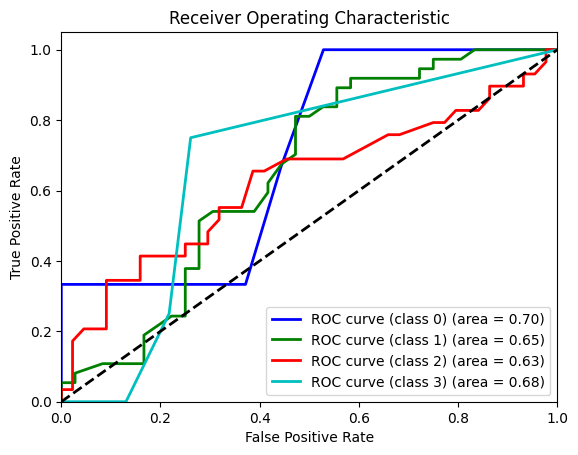

In [153]:
# Plot ROC AUC curve for each class
n_classes = 4  # Four classes (1, 2, 3, and 4)
fpr = dict()
tpr = dict()
roc_auc = dict()

#print(X_test)
#print(model.predict_proba(X_test))
for i in range(n_classes):
    y_test_class_i = (y_test == i).astype(int)
    y_score = model.predict_proba(X_test)[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_test_class_i, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['b', 'g', 'r', 'c']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (class {0}) (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()